In [142]:
import requests
import json
import pandas as pd
import time
import re
import urllib
import matplotlib
import numpy as np
pd.set_option('display.max_colwidth', None)

In [143]:
import boto3
from io import StringIO

In [144]:
try:
    df = pd.read_csv("./data/astro/swaps.csv")
    df.timestamp = pd.to_datetime(df.timestamp, format='mixed')
except Exception as e:
    print(f"No file yet {e}")
    df = None

In [145]:
assets = {
    'ibc/B3504E092456BA618CC28AC671A71FB08C6CA0FD0BE7C8A5B5A3E2DD933CC9E4':'axlUSDC',
    'terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26':'ASTRO'
}

In [146]:
df = df.drop_duplicates(ignore_index=True)
df.returnAsset = df.returnAsset.replace(assets)
df.offerAsset = df.offerAsset.replace(assets)

In [147]:
df['date'] = df.timestamp.apply(lambda x: x.strftime("%Y-%m-%d"))

In [148]:
_sell = df[df.offerAsset=='ASTRO']
_buy = df[df.returnAsset=='ASTRO']
_sell['astro_amount'] =  - _sell.offerAmount
_buy['astro_amount'] =  _buy.returnAmount
df = pd.concat([_sell, _buy])

/tmp/ipykernel_48/2204474832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _sell['astro_amount'] =  - _sell.offerAmount
/tmp/ipykernel_48/2204474832.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _buy['astro_amount'] =  _buy.returnAmount


In [149]:
tokens = [
"xASTRO",
"SAYVE",
"ORNE",
"ASTRO",
"ampLUNA",
"ROAR",
"boneLuna"
]

In [150]:
import requests
import json

def get_balances(address):
    url = "https://starscream-terra-mainnet.chainscope.dev/"
    headers = {
        "Content-Type": "application/json"
    }
    
    body = {
        "query": """
        query Query($address: String!, $tokenContracts: [String!]!) {
            tokenBalances(address: $address, tokenContracts: $tokenContracts)
        }
        """,
        "variables": {
            "address": f"{address}",
            "tokenContracts": [
                "terra1x62mjnme4y0rdnag3r8rfgjuutsqlkkyuh4ndgex0wl3wue25uksau39q8",
                "terra1xp9hrhthzddnl7j5du83gqqr4wmdjm5t0guzg9jp6jwrtpukwfjsjgy4f3",
                "terra19p20mfnvwh9yvyr7aus3a6z6g6uk28fv4jhx9kmnc2m7krg27q2qkfenjw",
                "terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26",
                "terra1ecgazyd0waaj3g7l9cmy5gulhxkps2gmxu9ghducvuypjq68mq2s5lvsct",
                "terra1lxx40s29qvkrcj8fsa3yzyehy7w50umdvvnls2r830rys6lu2zns63eelv",
                "terra17aj4ty4sz4yhgm08na8drc0v03v2jwr3waxcqrwhajj729zhl7zqnpc0ml"
            ]
        },
        "operationName": "Query"
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        result = response.json()
        return result
    else:
        print("Request failed with status code:", response.status_code)

In [151]:
addresses = set(df.traderAddress.tolist())

In [154]:
balances = []
for address in addresses:
    try:
        balance_dict = {k: int(v)/1000000 for k, v in zip(tokens, get_balances(address)['data']['tokenBalances'])}
        balance_dict['traderAddress']= address
        balances.append(balance_dict)
    except:
        print(f"Error processing: {address}")

In [155]:
balances_df = pd.DataFrame(balances)
balances_df['total_astro_holdings'] = balances_df['ASTRO'] + balances_df['xASTRO']

In [156]:
df_ = pd.DataFrame(balances_df).merge(df, on='traderAddress')

In [157]:
balances_df.total_astro_holdings.quantile(0.95)

132576.2435817998

In [161]:
whales = balances_df[balances_df.total_astro_holdings > balances_df.total_astro_holdings.quantile(0.95)]
whales

,xASTRO,SAYVE,ORNE,ASTRO,ampLUNA,ROAR,boneLuna,traderAddress,total_astro_holdings
13,1.540988e+05,0.000000,0.0,0.000000,1023.671885,2.888957e+05,4.280547,terra1h0w67ysrzstmrwyg4uckdzl88phf0r7qewrtj2,1.540988e+05
65,1.661056e+05,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.360562,terra1xtflxpujufdgckk9fr06cu204yyrnz5rypjc7v,1.661056e+05
78,5.279573e+05,0.000000,0.0,0.000000,0.000000,7.500000e+06,0.000000,terra1h69v6zum5yx89xsght7l9qeclm54zp8ec6ukj4,5.279573e+05
82,1.243329e+06,0.000000,0.0,0.000000,0.000000,1.084448e+07,0.000000,terra17k9pr86dq75k3lwh3v826jm8s69halgfhtk509,1.243329e+06
111,1.264761e+05,0.000000,0.0,50380.886699,0.000000,0.000000e+00,0.000000,terra17aq8zcd9644nshjfx8azh42mfpfn2kp0tqwzl4,1.768570e+05
119,3.036304e+05,0.000000,0.0,0.000000,0.000000,2.918053e+03,0.000000,terra13emdyum6s7v3vaew833euut7fd9ggw780ut3sj,3.036304e+05
127,4.001348e+05,0.000000,0.0,2168.818489,0.000000,0.000000e+00,0.000000,terra1ave3l9lnajt2q63u3dgd3p5qpqyr5ddue5576s,4.023037e+05
133,2.197393e+05,0.000000,0.0,0.000000,0.000000,6.394353e+07,0.000000,terra1f4q6rueku20ygq8wj8eyzv6csh0runf3cpx2qu,2.197393e+05
140,2.779931e+06,0.000000,0.0,1682.581393,0.000000,2.500000e+06,0.000000,terra1nqe6uk0lqcrathtav4vhsfl65cqw75qyj89j74,2.781614e+06
163,2.523255e+06,0.000000,0.0,8650.325321,0.000000,0.000000e+00,0.000000,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2.531906e+06


In [159]:
daily_delta = df[['traderAddress','date','astro_amount']].groupby(['traderAddress','date']).sum().reset_index()

In [160]:
daily_delta[["traderAddress","astro_amount"]].groupby(['traderAddress']).sum().reset_index().sort_values(by='astro_amount')

,traderAddress,astro_amount
116,terra147vzdxzn5tq4fm7z6f5q8x46xfha7e34w4sy9j,-1.168698e+06
467,terra1evtkrqahmavh4t5x6squzpwfcr4nl5ssj67edz,-1.089544e+06
749,terra1pgvewpk8kd30f2zm85sn69k9cgkp3j8szq00j7,-7.853898e+05
97,terra13vr7ewxzvaz6nj299qqt0d6w0qwqjwhu53xnrh,-7.561296e+05
51,terra12nz7cd6zyn95jhz7v923cf7sg49vpxxmy5r79p,-7.423204e+05
...,...,...
1064,terra1zakne2kmp78fp477vaqxunj0tl27leqglkc2hw,4.764188e+05
67,terra135z8ugx4gtu2ys58rt5utk3f50lwh0qxuln7ml,6.065280e+05
407,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,7.554060e+05
303,terra19k3s3gv5pfm3kh4utry9ty0hsulc2n8sv5shu8,9.332778e+05


In [165]:
whales_movements_first_july = daily_delta[daily_delta.date>='2023-07-01'].merge(whales, on='traderAddress')
whales_movements_first_july

,traderAddress,date,astro_amount,xASTRO,SAYVE,ORNE,ASTRO,ampLUNA,ROAR,boneLuna,total_astro_holdings
0,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-01,32.235351,7.851481e+04,0.0,0.0,106711.389065,0.0,0.000000e+00,0.000000,1.852262e+05
1,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-03,902.923391,7.851481e+04,0.0,0.0,106711.389065,0.0,0.000000e+00,0.000000,1.852262e+05
2,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-06,284.907911,7.851481e+04,0.0,0.0,106711.389065,0.0,0.000000e+00,0.000000,1.852262e+05
3,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-07,2587.354644,7.851481e+04,0.0,0.0,106711.389065,0.0,0.000000e+00,0.000000,1.852262e+05
4,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-08,3511.545065,7.851481e+04,0.0,0.0,106711.389065,0.0,0.000000e+00,0.000000,1.852262e+05
...,...,...,...,...,...,...,...,...,...,...,...
106,terra1ynumtglc79tsjmekss76npyj2hqchql4p5456e,2023-07-19,1367.999724,1.436453e+06,0.0,0.0,0.000000,0.0,7.558532e+06,0.004405,1.436453e+06
107,terra1ys03rex4c3wu92e6yhqsm5lsu0tl476xv26ply,2023-07-11,18655.743497,1.804529e+05,0.0,0.0,411.837710,0.0,2.500000e+06,0.000000,1.808648e+05
108,terra1zakne2kmp78fp477vaqxunj0tl27leqglkc2hw,2023-07-07,174718.960108,3.029252e+06,0.0,0.0,37021.184339,0.0,6.006335e+08,0.000000,3.066273e+06
109,terra1zakne2kmp78fp477vaqxunj0tl27leqglkc2hw,2023-07-13,86365.343071,3.029252e+06,0.0,0.0,37021.184339,0.0,6.006335e+08,0.000000,3.066273e+06


<Axes: xlabel='traderAddress'>

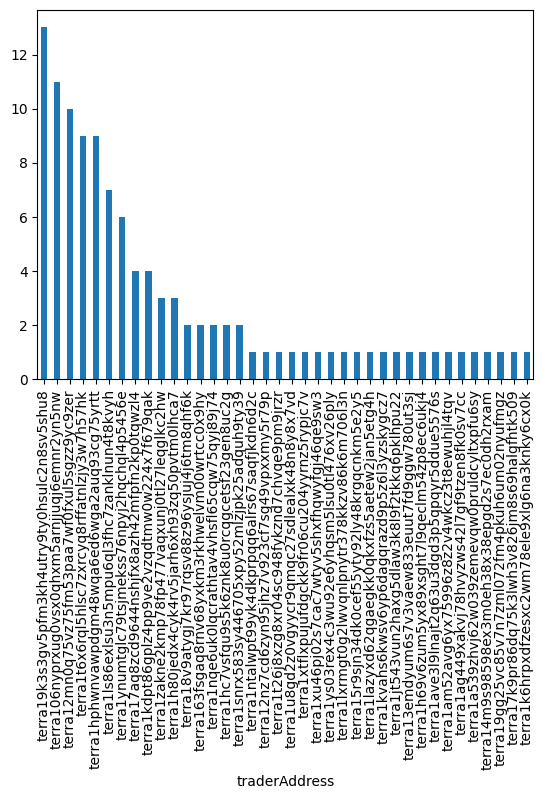

In [175]:
whales_movements_first_july.traderAddress.value_counts().plot(kind='bar')

In [187]:
index = 1

In [188]:
whales_movements_first_july[whales_movements_first_july.traderAddress==\
    whales_movements_first_july.traderAddress.value_counts().index[index]].astro_amount.sum()

343278.67486800003

In [189]:
whales_movements_first_july[whales_movements_first_july.traderAddress==\
    whales_movements_first_july.traderAddress.value_counts().index[index]]

,traderAddress,date,astro_amount,xASTRO,SAYVE,ORNE,ASTRO,ampLUNA,ROAR,boneLuna,total_astro_holdings
58,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-01,44251.852627,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
59,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-02,62822.928292,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
60,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-06,19951.706152,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
61,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-07,21666.510038,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
62,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-09,19369.316979,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
63,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-10,85619.022711,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
64,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-11,20992.599612,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
65,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-12,62423.270585,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
66,terra1hphwnvawpdgm48wqa6ed6wga2auq93cg75yrtt,2023-07-18,6181.467872,2.523255e+06,0.0,0.0,8650.325321,0.0,0.0,0.0,2.531906e+06
